# Shark Attack - Project 1

![elgif](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExYjZhODVlMTM4MmU0ZmQ5MmVjZmNkZTJjODRlNDQwOGE4YzQwODgzZCZjdD1n/41fVADWFuH310BFLvt/giphy.gif)

## Table of Content:

   #### 1 Import libraries
   #### 2 Hypothesis of this project
   #### 3 Data Cleaning
   #### 4 Fucntions
   #### 5 Sub-Dataframes
   #### 6 Visualizations

    

   ## 1 Import libraries

In [137]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import re

In [138]:
%matplotlib inline
%config Inlinebackend.figure_format= 'retina'

   ## 2 Hypothesis of this project

### Hypothesis --> Understand if Australia is the riskiest country to go surfing specially in the afternoon
   ##### A) Is there a trend YoY?
   ##### B) Which are the top 5 riskiest countries?
   ##### C) Is this risk fatal?
   ##### D) Is there any specific riskier Month?

   ## 3 Data Cleaning


In [140]:
df = pd.read_csv('C:/Users/maria/Desktop/Project_1_Pandas_Mariano/Data/attacks.csv', engine= 'python')
#Remove Columns Unnamed 22 and 23 since they don't have data at all
df.drop(['Unnamed: 22','Unnamed: 23'], axis=1, inplace=True)
#Capitalizing Counties since the data was all in upper
df.Country = df.Country.str.capitalize()
#Removing all the raws that contain too many NAN values
df.dropna(thresh=14, inplace=True)
#Rename Columns with spaces or too much info
df.rename(columns={"Sex ":"Sex", "Species ":"Species","Fatal (Y/N)":"Fatal"}, inplace=True)
#Creating a new column for last part of url -- objective- replace current pdf column as it's not complete
df['Url2'] = df['href'].str.split('/').str[-1]
#Creating a Last Name column from the url
df['Last_Name'] = df['Url2'].str.extract('([a-zA-Z]{4,})', expand=True)
#Creating First Name Column
df['First_Name'] = df['Name'].str.split(' ').str[0]
#Creating a 2nd date column from new url column
df['Date2'] = df['Url2'].str.extract('(\d{4}.\d{2}.\d{2})', expand=True)
#Creating columns for Day, Month and Year to check
df['Day'] = df['Date'].str.split('-').str[0]
df['Month'] = df['Date'].str.split('-').str[1]
#To consolidate mainly to Jan-Feb type of month strings (many inconsitencies before)
df['Month'] = df['Month'].str.extract('([a-zA-Z]{3,})', expand=True)
df['Year2'] = df['Date2'].str.extract('([0-9]{4})', expand=True)
#Splitting Inv.Source into 2 columns>
df['Investigator'] = df['Investigator or Source'].str.split(',').str[0]
df['Source'] = df['Investigator or Source'].str.split(',').str[1]

   ## 4 Fucntions

In [142]:
#Year_unique for determination of final year
def year_unique (row):
    if str(row['Year']) != 'nan' and str(row['Year2']) != 'nan':
        if str(row['Year']) == str(row['Year2']):
            return int(row['Year'])
        elif len(str(row['Year'])) <= 5:
            return int(row['Year'])
        elif len(str(row['Year2'])) <= 5:
            return int(row['Year2'])
        else:
            return 0
    elif str(row['Year']) == 'nan' and str(row['Year2']) != 'nan':
        if len(str(row['Year2'])) <= 5:
            return int(row['Year2'])
        else:
            return 0
    else:
        return 0
df['Year_Unique'] = df.apply(lambda row: year_unique(row), axis=1)
#Creating Hour column
df['Hour'] = df['Time'].str.extract('([0-9]{2})', expand=True)
#Creating Func for time range to determine moment of the day
def time_range (row):
    if str(row['Hour']) != 'nan':
        if int(row['Hour']) > 6 and int(row['Hour']) < 14:
            return 'Morning'
        elif int(row['Hour']) >= 14 and int(row['Hour']) < 22:
            return 'Afternoon'
        else:
            return 'Evening'
    #There were many Uknown in the past since many rows in Time were strings with words contaning time-range, by adding this
    #we avoid having situations of unknowns but still is an option in case there is any
    elif str(row['Time']).lower().find('afternoon'):
        return 'Afternoon'
    elif str(row['Time']).lower().find('morning'):
        return 'Morning'
    elif str(row['Time']).lower().find('evening'):
        return 'Evening'
    else:
        return 'Unknown'
#Creating Time Range column applying the func
df['Time_Range'] = df.apply(lambda row: time_range(row), axis=1)
#Creating Category gorup func to agroupate activities with less granularity
def category (row):
    if str(row['Activity']) != 'nan':
        if str(row['Activity']) in ['Surfing','Standing']:
            return 'Surfing'
        elif str(row['Activity']) in ['Swimming','Bathing']:
            return 'Swimming'
        elif str(row['Activity']) in ['Fishing','Wading']:
            return 'Fishing'
        elif str(row['Activity']) in ['Diving','Snorkeling','Spearfishing','Scuba diving']:
            return 'Diving'
        else:
            return 'Other Activity'
    else:
        return 'Unknown'
#Creating Activity Category group column
df['Activity_Category'] = df.apply(lambda row: category(row), axis=1)
#Creating TimeRange-Act.Category gorup func to join both categories:
def TimeR_ActCat (row):
    if str(row['Time_Range']) != 'nan' and str(row['Activity_Category']) != 'nan':
        return str(row['Time_Range']) + str(row['Activity_Category'])
    else:
        return 'Unknown'
#Creating TimeRange-Act.Category group column
df['TimeRange-ActCategory'] = df.apply(lambda row: TimeR_ActCat(row), axis=1)

   ## 5 Sub-Dataframes

In [143]:
#Creating a sub-df for analysis
sub_df = df[['Year_Unique', 'Date2', 'Day', 'Month', 'Hour', 'Time_Range',
          'Country', 'Area', 'Type', 'Injury', 'Fatal', 'Species',
            'First_Name','Last_Name','Sex', 'Age','Activity_Category','TimeRange-ActCategory']]
#Creating Second Subdata set filtered with Year >2000
sub_df2= sub_df[sub_df["Year_Unique"] >2000]
#Modifying value manually
sub_df2.loc[463, "Year_Unique"] = 2014
sub_df2 = sub_df2.sort_values(by="Year_Unique", ascending=False)
#Creating a top 5 Countries with most shark attacks from 2000 onwards (sub_df2)
top_5_df = sub_df2.query("Country in ('Usa','Australia','South africa','Brazil','Bahamas')")

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [84]:
df.columns

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex', 'Age', 'Injury', 'Fatal', 'Time', 'Species',
       'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Url2', 'Last_Name',
       'First_Name', 'Date2', 'Day', 'Month', 'Year2', 'Investigator',
       'Source', 'Year_Unique', 'Hour', 'Time_Range', 'Activity_Category',
       'TimeRange-ActCategory'],
      dtype='object')

   ## 6 Visualizations

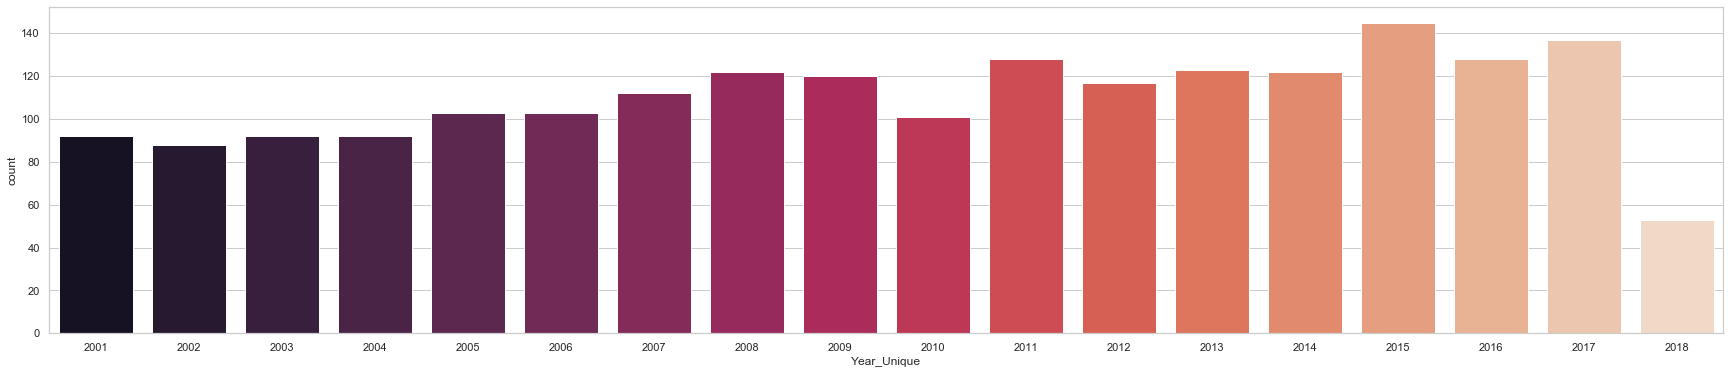

In [85]:
sns.countplot(x=sub_df2.Year_Unique, palette="rocket")
sns.set_context("poster")
sns.set(rc={"figure.figsize": (30 ,6)})
sns.set_style("whitegrid");

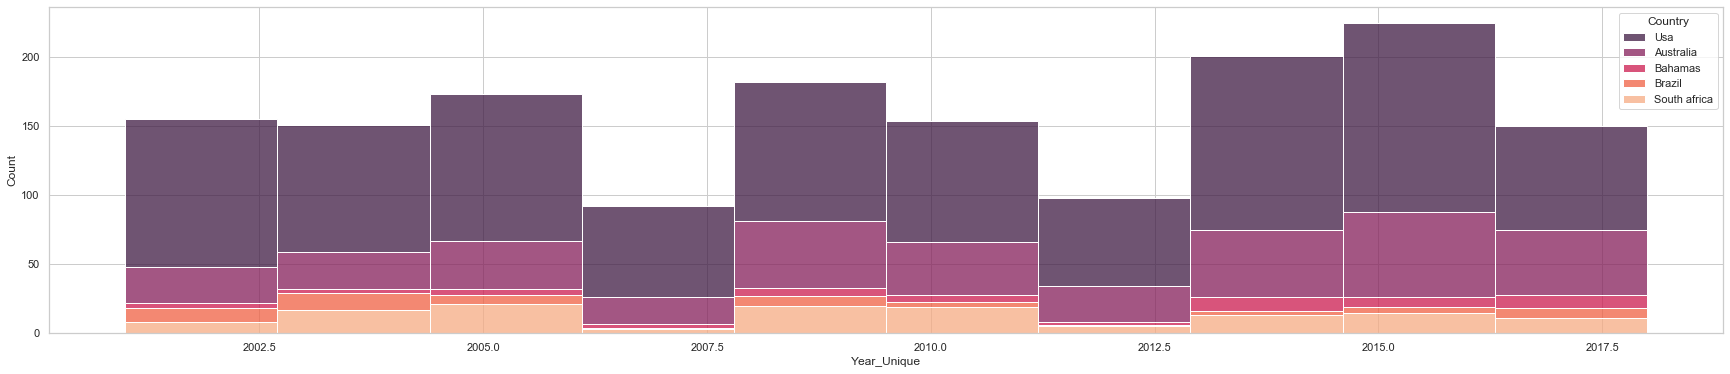

In [118]:
sns.histplot(data=top_5_df, x= "Year_Unique", hue="Country", multiple="stack", palette="rocket", bins=10)
sns.set_style("whitegrid");

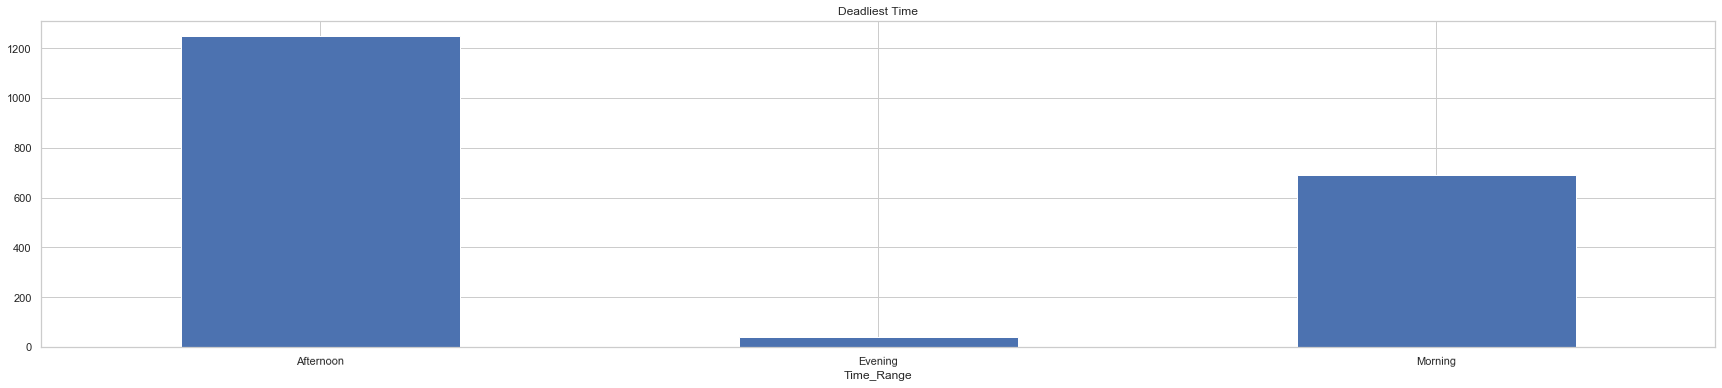

In [87]:
sub_df2.groupby("Time_Range")["Year_Unique"].count().plot(kind="bar", title="Deadliest Time")
plt.xticks(rotation=0.5);

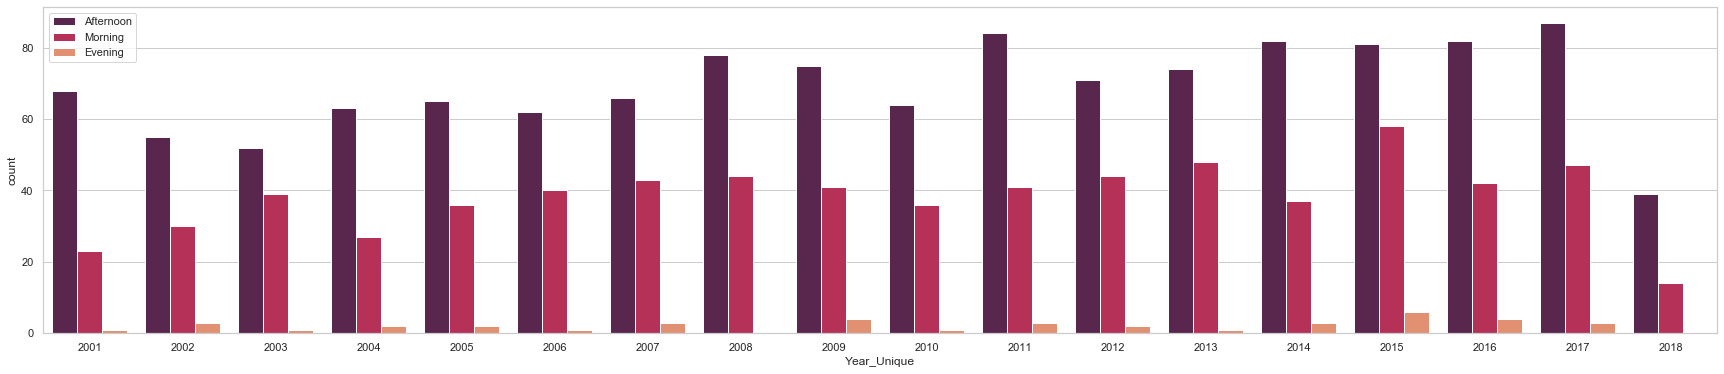

In [88]:
sns.countplot(x=sub_df2["Year_Unique"], hue=sub_df2["Time_Range"], palette="rocket")
plt.legend(labels = ['Afternoon', 'Morning', 'Evening']);

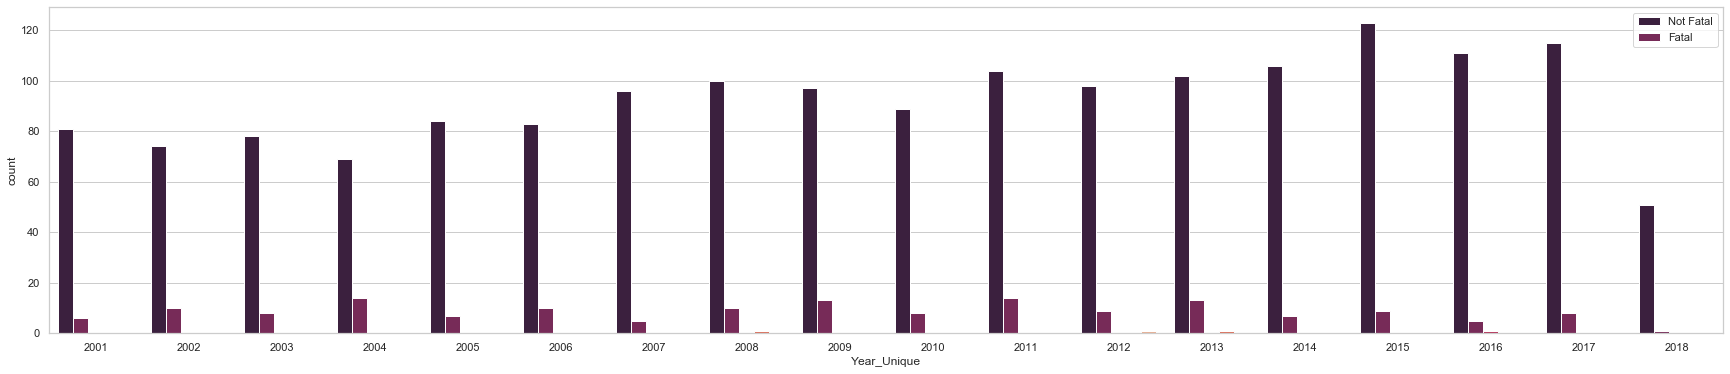

In [89]:
sns.countplot(x=sub_df2["Year_Unique"], hue=sub_df2["Fatal"], palette="rocket")
plt.legend(labels = ['Not Fatal', 'Fatal']);

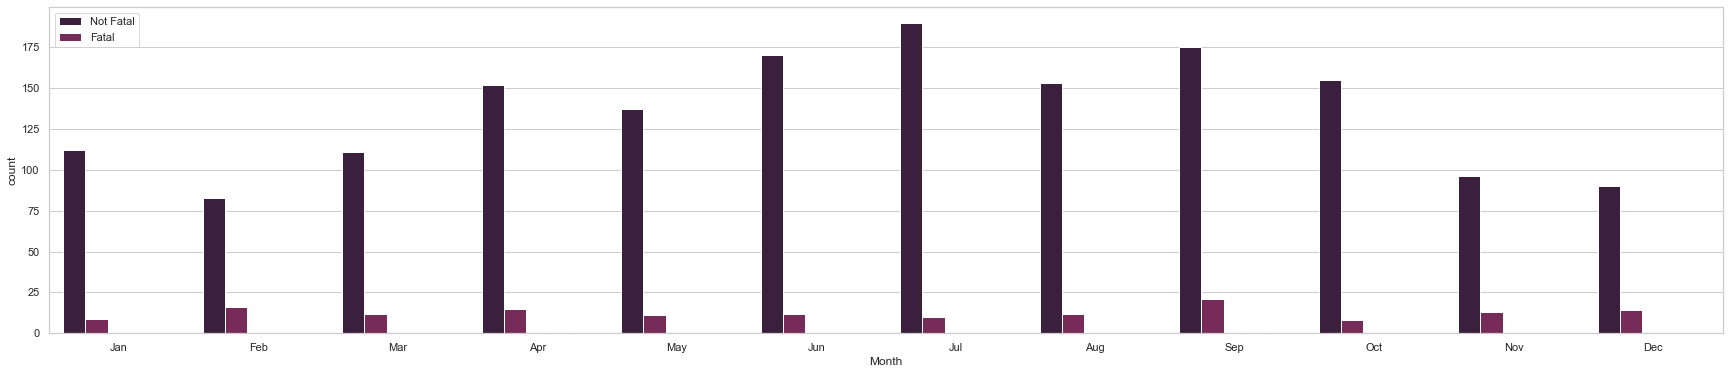

In [108]:
sns.countplot(x=sub_df2["Month"], hue=sub_df2["Fatal"], palette="rocket", 
              order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend(labels = ['Not Fatal', 'Fatal']);

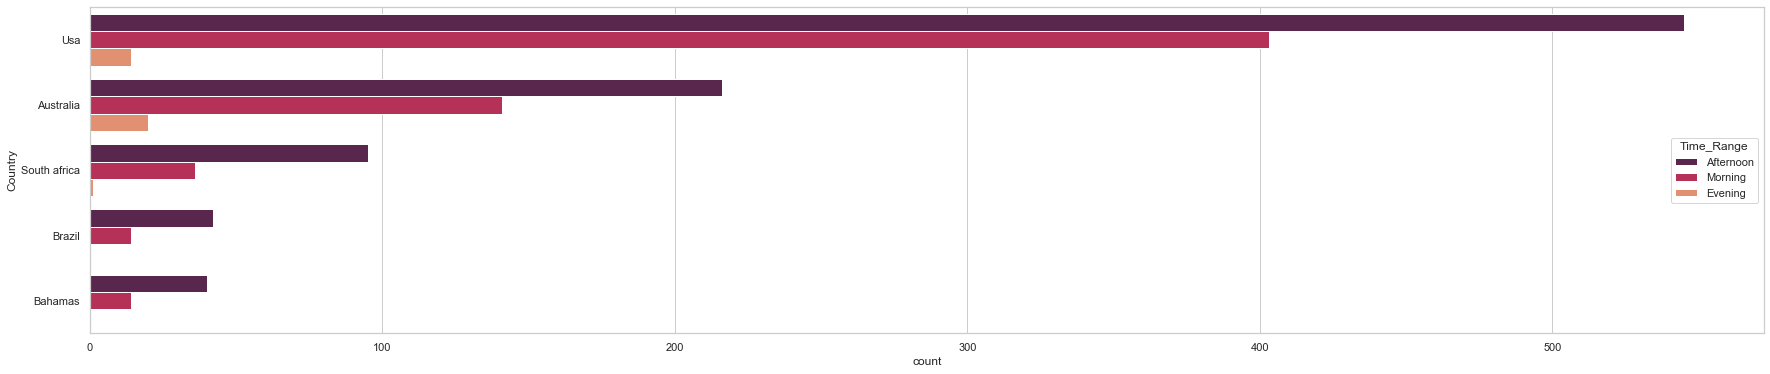

In [91]:
sns.countplot(y="Country", hue="Time_Range", data=sub_df2, palette="rocket",
              order=sub_df2.Country.value_counts().iloc[:5].index);

In [92]:
#This was another way using loc instad of another DF but it was better making ahother DF for top 5 countries
#sub_df2.groupby('Country')['Time_Range'].value_counts(normalize = True).unstack().fillna(0).loc[['Usa','Australia','South africa','Brazil','Bahamas']].plot(kind="bar", title="Deadliest Time")
#plt.xticks(rotation=0.5);

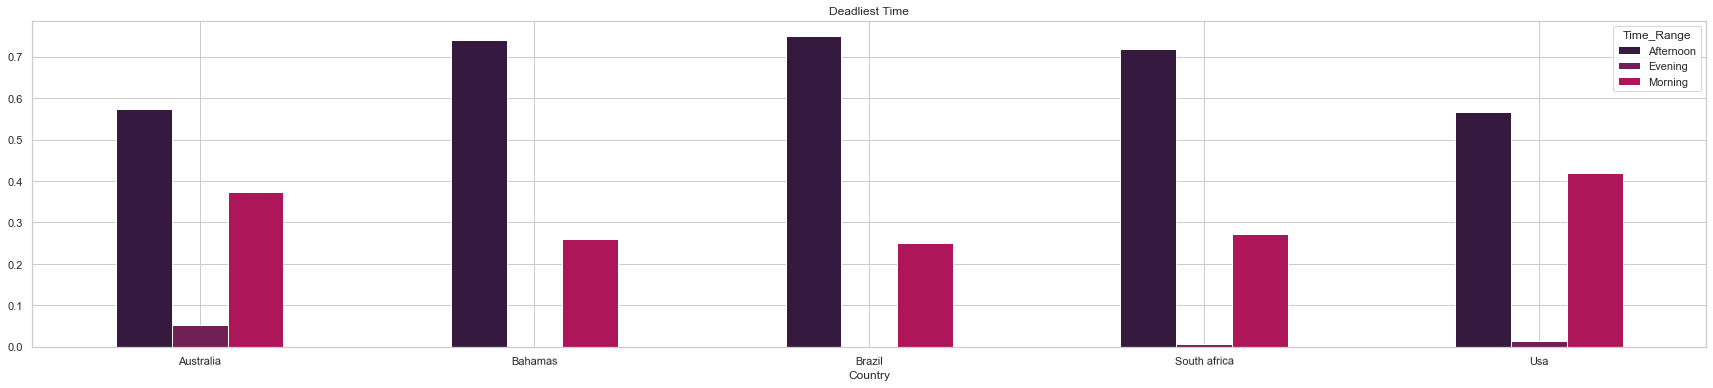

In [114]:
fig1 = top_5_df.groupby('Country')['Time_Range'].value_counts(normalize = True).unstack().fillna(0).plot(kind="bar", title="Deadliest Time")
fig1
.axvline(x=titanic.Age.mean(), c="red", label="mean")
sns.set_palette("rocket")
plt.xticks(rotation=0.5);

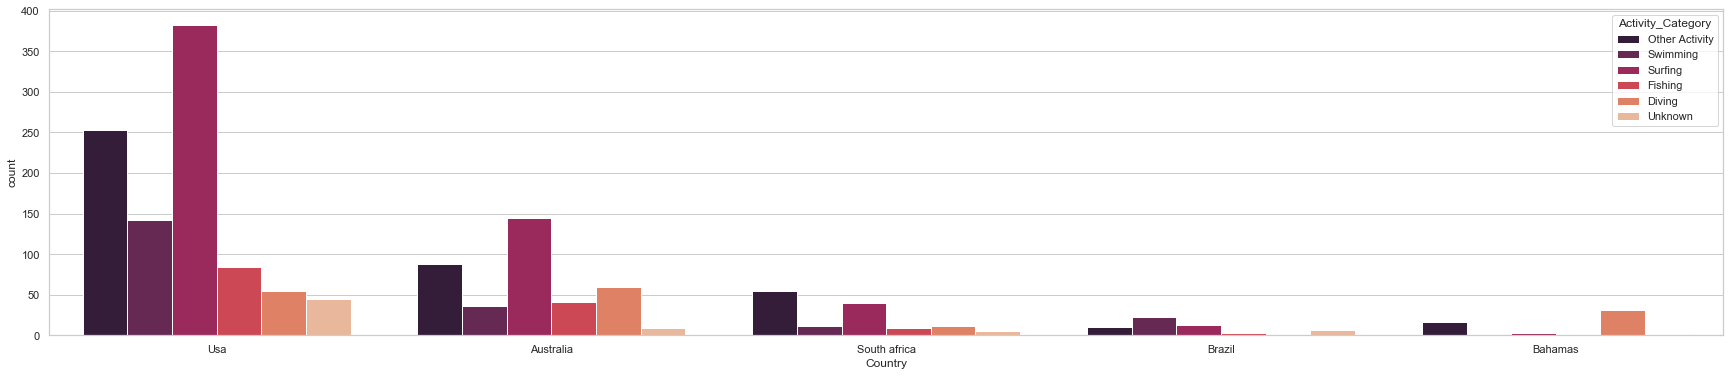

In [94]:
sns.countplot(x="Country", hue="Activity_Category", data=top_5_df, palette="rocket",
              order=top_5_df.Country.value_counts().index);

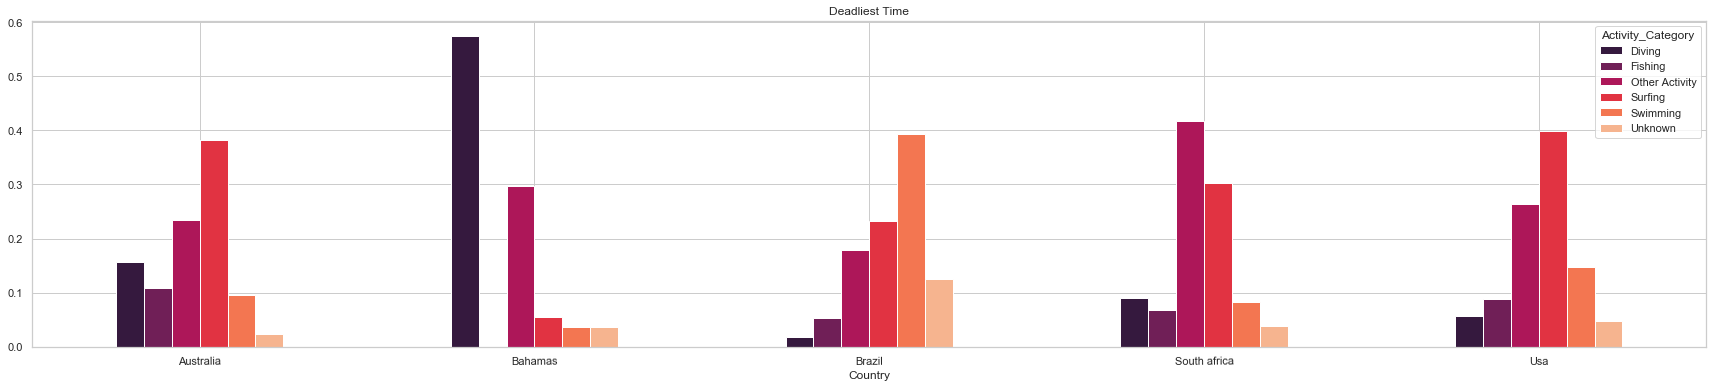

In [115]:
top_5_df.groupby('Country')['Activity_Category'].value_counts(normalize = True).unstack().fillna(0).plot(kind="bar", title="Deadliest Time")
sns.set_palette("rocket")
plt.xticks(rotation=0.5);

In [96]:
top_5_df.groupby('Country')['Time_Range'].value_counts(normalize = True).unstack().fillna(0)

Time_Range,Afternoon,Evening,Morning
Country,,,
Australia,0.572944,0.053050,0.374005
Bahamas,0.740741,0.000000,0.259259
Brazil,0.750000,0.000000,0.250000
South africa,0.719697,0.007576,0.272727
Usa,0.566528,0.014553,0.418919


In [97]:
top_5_df.groupby('Country')['TimeRange-ActCategory'].value_counts(normalize = True).unstack().fillna(0)

TimeRange-ActCategory,AfternoonDiving,AfternoonFishing,AfternoonOther Activity,AfternoonSurfing,AfternoonSwimming,AfternoonUnknown,EveningFishing,EveningOther Activity,EveningSurfing,EveningSwimming,MorningDiving,MorningFishing,MorningOther Activity,MorningSurfing,MorningSwimming,MorningUnknown
Country,,,,,,,,,,,,,,,,
Australia,0.092838,0.068966,0.119363,0.206897,0.063660,0.021220,0.005305,0.007958,0.037135,0.002653,0.063660,0.034483,0.106101,0.137931,0.029178,0.002653
Bahamas,0.388889,0.000000,0.277778,0.018519,0.018519,0.037037,0.000000,0.000000,0.000000,0.000000,0.185185,0.000000,0.018519,0.037037,0.018519,0.000000
Brazil,0.017857,0.053571,0.107143,0.178571,0.285714,0.107143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.053571,0.107143,0.017857
South africa,0.060606,0.045455,0.318182,0.189394,0.068182,0.037879,0.007576,0.000000,0.000000,0.000000,0.030303,0.015152,0.098485,0.113636,0.015152,0.000000
Usa,0.027027,0.048857,0.161123,0.205821,0.087318,0.036383,0.001040,0.005198,0.006237,0.002079,0.030146,0.037422,0.096674,0.186071,0.058212,0.010395


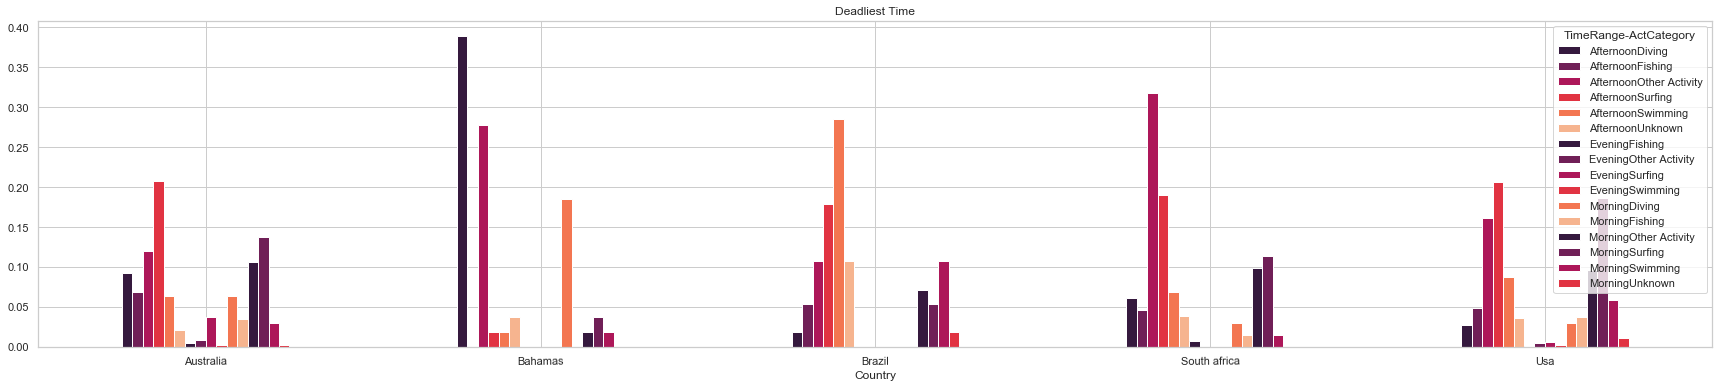

In [116]:
top_5_df.groupby('Country')['TimeRange-ActCategory'].value_counts(normalize = True).unstack().fillna(0).plot(kind="bar", title="Deadliest Time")
sns.set_palette("rocket")
plt.xticks(rotation=0.5);

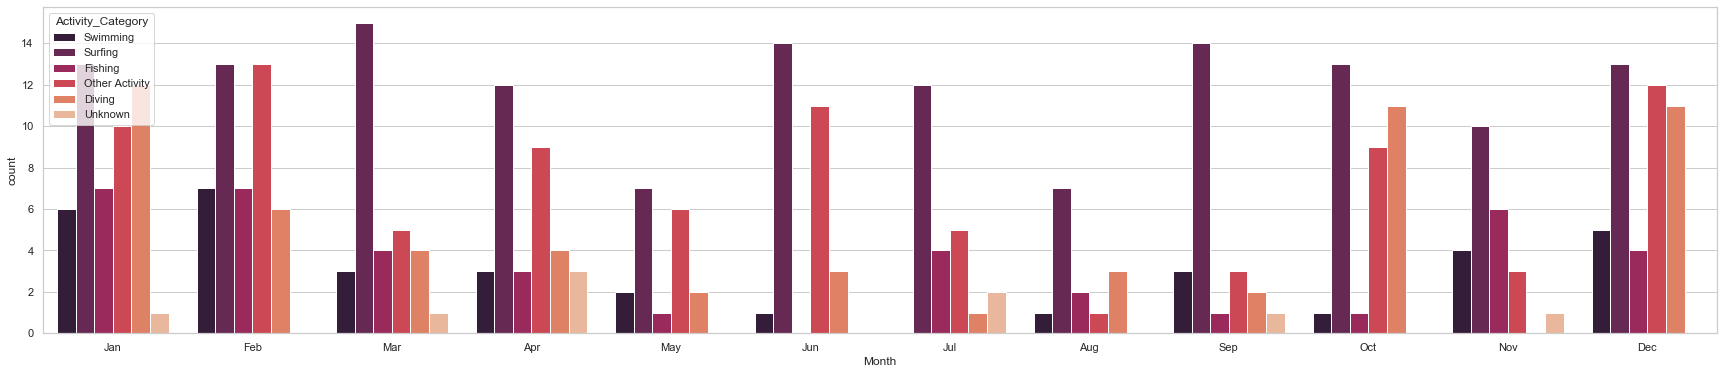

In [119]:
sns.countplot(x="Month", hue="Activity_Category", data=top_5_df[top_5_df['Country']=='Australia'], palette="rocket",
             order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']);